In [1]:
# Parameters for this script
num_features={"waveclus": 10, "PCA":2, "UMAP":2}    # Optimal dimmensionality
fscore_results={}         # dictionary where results will be saved
confmat_results={}         # dictionary where results will be saved
delta=2                    # Parameter to indicate if both spikes are the same shifted in samples 
min_features=2            # Minimimum dimensionality or # of components to explore.
maximum_features=15       # Maximum dimensionality to explore


#--------------------------------------------------------------------------------------------------------------
# importing libraries
import numpy as np
from scipy.io import loadmat
#import spikeforest as sf
import matplotlib.pyplot as plt
#from busz_funcs import pk, pts_extraction, butter_bandpass_filter_zi, load_kachery
#from toposort.preprocessing import spike_denoiser as denoiser, spike_aligner as aligner
import umap
import hdbscan
from scipy.spatial.distance import cdist
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA 
#from quiroga import *
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import random
#import umap.plot
import pywt
from scipy import stats
import pickle as pkl        # probably Vik needs to install this library, 
import SpkSort as s
from os import path as p
from os import listdir
#plt.style.use('fivethirtyeight')
plt.rcParams['svg.fonttype'] = 'none'     # Export svg text as text and not paths!

# FOr silencing warnings
import warnings
warnings.filterwarnings("ignore")


#
path="/media/sparra/HDD/article_spike_sorting/Simulator/"
namefile, noiselevel= ("C_Difficult1_noise02.mat", 0.15)

spikes, labels, spike_times = s.load_quiroga_spikes(p.join(path, namefile) )  
clusters=np.unique(labels)
denoised = s.denoiser(spikes)
spikes2 = s.aligner(denoised, alignment="tukey", window_length=30, upsample_rate=8)

/home/sparra/anaconda3/envs/py11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


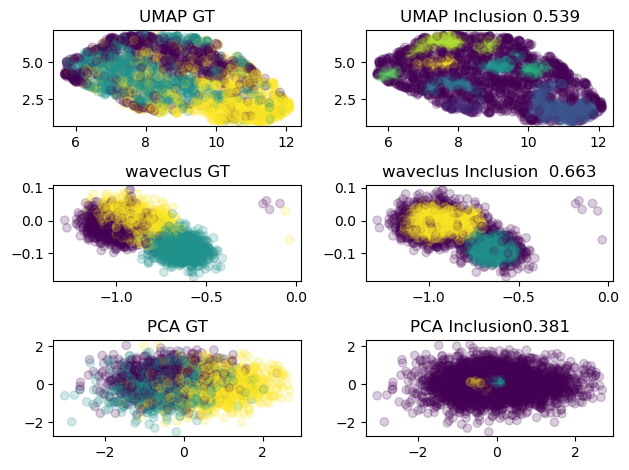

In [25]:
reducer_umap= umap.UMAP(min_dist=0.00, n_neighbors=30, n_components=2, n_epochs=2000, random_state=0, metric="manhattan").fit(spikes2)
reducer_waveclus = s.waveclus(spikes2, 4)
reducer_pca= PCA(2).fit_transform(spikes2)

clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=55, min_samples=50, cluster_selection_epsilon=0.35).fit(reducer_umap.embedding_)
#
clusterer_pca = hdbscan.HDBSCAN(min_cluster_size=55, min_samples=50, cluster_selection_epsilon=0.35).fit(reducer_pca)
#
clusterer_waveclus = hdbscan.HDBSCAN(min_cluster_size=55, min_samples=50, cluster_selection_epsilon=0.35).fit(reducer_waveclus)


fig, axes=plt.subplots(3, 2)

axes[0,0].scatter(reducer_umap.embedding_[:, 0], reducer_umap.embedding_[:, 1], c=labels, alpha=0.2)
fscore_tmp, incl_val_umap, matrix, inclusion_mat =s.f_recording2(spike_times, labels, clusterer_umap.labels_, delta, return_conf_mat=True)
axes[0,0].set_title("UMAP GT")
axes[0,1].set_title("UMAP Inclusion %.3f"%(incl_val_umap))
axes[0,1].scatter(reducer_umap.embedding_[:, 0], reducer_umap.embedding_[:, 1], c=clusterer_umap.labels_, alpha=0.2)
#
axes[1,0].scatter(reducer_waveclus[:, 0], reducer_waveclus[:, 1], c=labels, alpha=0.2)
fscore_tmp, incl_val_waveclus, matrix, inclusion_mat =s.f_recording2(spike_times, labels, clusterer_waveclus.labels_, delta, return_conf_mat=True)
axes[1,0].set_title("waveclus GT")
axes[1,1].set_title("waveclus Inclusion  %.3f"%(incl_val_waveclus))
axes[1, 1].scatter(reducer_waveclus[:, 0], reducer_waveclus[:, 1], c=clusterer_waveclus.labels_, alpha=0.2)

#
axes[2,0].scatter(reducer_pca[:, 0], reducer_pca[:, 1], c=labels, alpha=0.2)
fscore_tmp, incl_val_PCA, matrix, inclusion_mat =s.f_recording2(spike_times, labels, clusterer_pca.labels_, delta, return_conf_mat=True)
axes[2,0].set_title("PCA GT")
axes[2,1].set_title("PCA Inclusion%.3f"%(incl_val_PCA))
axes[2,1].scatter(reducer_pca[:, 0], reducer_pca[:, 1], c=clusterer_pca.labels_, alpha=0.2)
fig.tight_layout()

fig.savefig("difficult1_noise2.png", dpi=500)